# Car price prediction

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.metrics import mean_squared_error , max_error, mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true)))

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

RANDOM_SEED=42

## Preprocessing and EDA

In [2]:
df = pd.read_csv('train.csv')
df.head(3)

,Unnamed: 0,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,...,description,mileage,Комплектация,Привод,Руль,Владельцы,ПТС,Таможня,Владение,Price
0,0,Седан,AUDI,040001,бензин,1990.0,2.3 MT (133 л.с.),4.0,1991,MECHANICAL,...,\nБыстрым торг.Обмен интересен на авто с неисп...,10000,{'id': '0'},передний,LEFT,3.0,ORIGINAL,True,NaN,135000
1,1,Седан,AUDI,040001,бензин,1988.0,2.0 MT (115 л.с.),4.0,1989,MECHANICAL,...,На ходу!Очень много сделано!До аварии ездил 1....,300000,{'id': '0'},передний,LEFT,3.0,DUPLICATE,True,NaN,42000
2,2,Универсал 5 дв.,AUDI,CACECB,бензин,1990.0,2.3 MT (133 л.с.),5.0,1991,MECHANICAL,...,Новый перешитый потолок. \nМашина на полном ходу,205636,{'id': '0'},передний,LEFT,2.0,ORIGINAL,True,NaN,200000


In [3]:
df.columns

Index(['Unnamed: 0', 'bodyType', 'brand', 'color', 'fuelType', 'modelDate',
       'name', 'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'engineDisplacement', 'enginePower', 'description', 'mileage',
       'Комплектация', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'Таможня',
       'Владение', 'Price'],
      dtype='object')

In [4]:
df.iloc[2]

Unnamed: 0                                                             2
bodyType                                                 Универсал 5 дв.
brand                                                               AUDI
color                                                             CACECB
fuelType                                                          бензин
modelDate                                                           1990
name                                                   2.3 MT (133 л.с.)
numberOfDoors                                                          5
productionDate                                                      1991
vehicleConfiguration                                          MECHANICAL
engineDisplacement                                                   2.3
enginePower                                                          133
description             Новый перешитый потолок. \nМашина на полном ходу
mileage                                            

In [5]:
df.shape

(109080, 22)

In [6]:
# Percent of missing values
df.isna().sum() / (df.shape[0])*100 

Unnamed: 0               0.000000
bodyType                 0.000917
brand                    0.000000
color                    0.000000
fuelType                 0.000000
modelDate                0.000917
name                     0.000917
numberOfDoors            0.000917
productionDate           0.000000
vehicleConfiguration     0.000917
engineDisplacement       0.000917
enginePower              0.000917
description              2.980381
mileage                  0.000000
Комплектация             0.000000
Привод                   0.000917
Руль                     0.000000
Владельцы                0.006417
ПТС                      0.001834
Таможня                  0.000000
Владение                63.431426
Price                    0.000000
dtype: float64

In [7]:
df.Таможня.unique()

array([ True])

In [8]:
df['Комплектация'].value_counts()[:2]

{'id': '0'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               77978
{'id': '4562904', 'name': 'Elegance', 'available_options': ['cruise-control', 'multi-wheel', 'airbag-passenger', 'lock', 'electro-mirrors', 'mirrors-heat', 'cooling-box', 'computer', 'seat-transformation', 'wheel-power', 'fabric-seats', 'airbag-side', 'abs', 'wheel-leather', 'climate-control-1', 'esp', 'audiopreparation', 'electro-window-back', 'condition', 'music-super', 'park-assist-r', 

We have to delete some columns:
- Unnamed: 0 - we don't need the index of object
- description - in this case, we can't use RNN for NLP task
- Таможня - has only 1 value: True
- Владение - over 60% of all values - missing
- name - converted to 2 single columns: engineDisplacement and enginePower
- Комплектация - over 60% of all values are missing: {'id': '0'}

In [9]:
df.drop(['Unnamed: 0','description','Таможня','Владение','name','Комплектация'],axis=1,inplace=True)
df.dropna(inplace=True)

In [10]:
df.head(3)

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Price
0,Седан,AUDI,040001,бензин,1990.0,4.0,1991,MECHANICAL,2.3,133.0,10000,передний,LEFT,3.0,ORIGINAL,135000
1,Седан,AUDI,040001,бензин,1988.0,4.0,1989,MECHANICAL,2.0,115.0,300000,передний,LEFT,3.0,DUPLICATE,42000
2,Универсал 5 дв.,AUDI,CACECB,бензин,1990.0,5.0,1991,MECHANICAL,2.3,133.0,205636,передний,LEFT,2.0,ORIGINAL,200000


In [11]:
df.isna().sum() / (df.shape[0])*100 

bodyType                0.0
brand                   0.0
color                   0.0
fuelType                0.0
modelDate               0.0
numberOfDoors           0.0
productionDate          0.0
vehicleConfiguration    0.0
engineDisplacement      0.0
enginePower             0.0
mileage                 0.0
Привод                  0.0
Руль                    0.0
Владельцы               0.0
ПТС                     0.0
Price                   0.0
dtype: float64

### Encoding

In [12]:
df.dtypes

bodyType                 object
brand                    object
color                    object
fuelType                 object
modelDate               float64
numberOfDoors           float64
productionDate            int64
vehicleConfiguration     object
engineDisplacement       object
enginePower             float64
mileage                   int64
Привод                   object
Руль                     object
Владельцы               float64
ПТС                      object
Price                     int64
dtype: object

In [13]:
df.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'numberOfDoors',
       'productionDate', 'vehicleConfiguration', 'engineDisplacement',
       'enginePower', 'mileage', 'Привод', 'Руль', 'Владельцы', 'ПТС',
       'Price'],
      dtype='object')

In [14]:
df.nunique()

bodyType                  112
brand                      13
color                      16
fuelType                    5
modelDate                  70
numberOfDoors               5
productionDate             73
vehicleConfiguration        4
engineDisplacement        431
enginePower               330
mileage                 23363
Привод                      3
Руль                        2
Владельцы                   3
ПТС                         2
Price                    5709
dtype: int64

In [15]:
# Decrease length of bodyType column from 2-3 words to 1 word ('Компактвэн Gran Tourer' -> 'Компактвэн') 
df['bodyType'] = df['bodyType'].apply(lambda x: x.split()[0])

For correct processing we will add train and submission data:

In [16]:
submission_data = pd.read_csv('prepared_submission_data.csv')
submission_data.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)
submission_data.head()

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС
0,Лифтбек,SKODA,0000CC,бензин,2013,5,2014,ROBOT,1.2,105.0,74000,передний,LEFT,3.0,ORIGINAL
1,Лифтбек,SKODA,040001,бензин,2017,5,2017,MECHANICAL,1.6,110.0,60563,передний,LEFT,1.0,ORIGINAL
2,Лифтбек,SKODA,97948F,бензин,2013,5,2014,ROBOT,1.8,152.0,88000,передний,LEFT,1.0,ORIGINAL
3,Лифтбек,SKODA,200204,бензин,2013,5,2014,AUTOMATIC,1.6,110.0,95000,передний,LEFT,1.0,ORIGINAL
4,Лифтбек,SKODA,FAFBFB,бензин,2008,5,2012,AUTOMATIC,1.8,152.0,58536,передний,LEFT,1.0,ORIGINAL


In [17]:
submission_data.dtypes

bodyType                 object
brand                    object
color                    object
fuelType                 object
modelDate                 int64
numberOfDoors             int64
productionDate            int64
vehicleConfiguration     object
engineDisplacement      float64
enginePower             float64
mileage                   int64
Привод                   object
Руль                     object
Владельцы               float64
ПТС                      object
dtype: object

In [18]:
submission_data['engineDisplacement'] = submission_data['engineDisplacement'].astype('str')

Convert labels from strings to integers by LabelEncoder:

In [19]:
categorical_columns = df.columns[df.dtypes == 'object']

for column in categorical_columns:
    le = preprocessing.LabelEncoder()
    print(column)
    le.fit(list(df[column])
          +list(submission_data[column]))
    
    df[column] = le.transform(list(df[column]))
    submission_data[column] = le.transform(list(submission_data[column]))

bodyType
brand
color
fuelType
vehicleConfiguration
engineDisplacement
Привод
Руль
ПТС


### Graphs and visualization

Plot correlation matrix:

In [20]:
corr = df.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "6pt")]),
            dict(selector="td",
                 props=[('padding', "0.4em 0.4em")]),
            dict(selector="th:hover",
                 props=[("font-size", "8pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '80px'),
                        ('font-size', '8pt'),
                        ('min-width','80px')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '12pt'})\
    .set_caption("correlation matrix")\
    .set_precision(2)\
    .set_table_styles(magnify())

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Price
bodyType,1.00,0.05,0.01,-0.19,-0.21,-0.41,-0.21,-0.01,-0.17,-0.29,0.16,-0.56,0.07,0.17,-0.10,-0.22
brand,0.05,1.00,0.09,-0.04,-0.03,0.10,-0.01,0.08,-0.35,-0.34,0.03,-0.01,0.06,-0.07,0.04,-0.15
color,0.01,0.09,1.00,-0.06,0.06,0.01,0.07,0.08,-0.14,-0.15,-0.07,-0.06,0.05,-0.07,0.04,-0.06
fuelType,-0.19,-0.04,-0.06,1.00,0.12,0.14,0.13,-0.20,0.17,0.05,-0.02,0.25,-0.03,-0.09,0.06,0.23
modelDate,-0.21,-0.03,0.06,0.12,1.00,0.17,0.97,0.09,0.06,0.23,-0.68,0.23,-0.20,-0.49,0.27,0.40
numberOfDoors,-0.41,0.10,0.01,0.14,0.17,1.00,0.18,0.09,-0.05,-0.01,-0.07,0.43,-0.02,-0.16,0.11,0.02
productionDate,-0.21,-0.01,0.07,0.13,0.97,0.18,1.00,0.09,0.04,0.20,-0.70,0.23,-0.21,-0.51,0.28,0.40
vehicleConfiguration,-0.01,0.08,0.08,-0.20,0.09,0.09,0.09,1.00,-0.29,-0.29,-0.11,-0.02,0.00,-0.12,0.05,-0.15
engineDisplacement,-0.17,-0.35,-0.14,0.17,0.06,-0.05,0.04,-0.29,1.00,0.66,-0.02,0.18,-0.04,0.06,-0.04,0.33
enginePower,-0.29,-0.34,-0.15,0.05,0.23,-0.01,0.20,-0.29,0.66,1.00,-0.17,0.34,-0.10,-0.01,-0.00,0.52


We can drop one of date columns - сorelation coeficient of them is 0.97

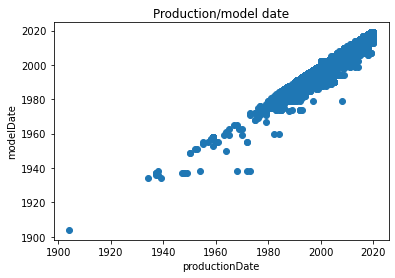

In [21]:
plt.title('Production/model date')
plt.xlabel('productionDate')
plt.ylabel('modelDate')
plt.scatter(df.productionDate,df.modelDate)

### Histograms

In [22]:
df.drop('modelDate',axis=1,inplace=True)

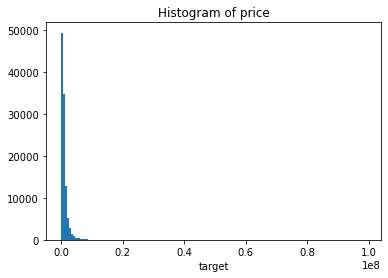

In [23]:
_ = plt.hist(df['Price'],bins = 150)
plt.title('Histogram of price')
plt.xlabel('target')
plt.show()

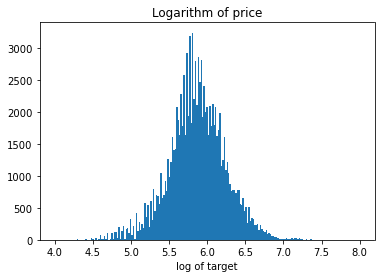

In [24]:
_ = plt.hist(np.log10(df['Price']),bins = 'auto')
plt.title('Logarithm of price')
plt.xlabel('log of target')
plt.show()

As we can see, logarithm of price has a normal distribution.

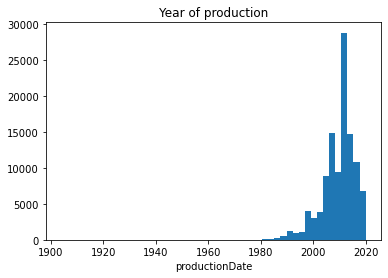

In [25]:
_ = plt.hist(df['productionDate'],bins = 50)
plt.title('Year of production')
plt.xlabel('productionDate')
plt.show()

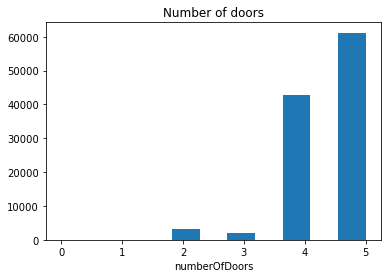

In [26]:
_ = plt.hist(df['numberOfDoors'],bins = 11)
plt.title('Number of doors')
plt.xlabel('numberOfDoors')
plt.show()

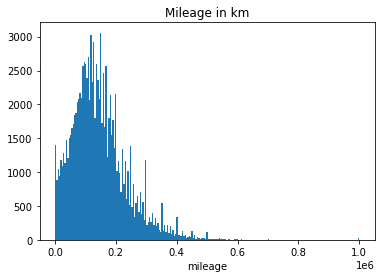

In [27]:
_ = plt.hist(df['mileage'],bins = 'auto')
plt.title('Mileage in km')
plt.xlabel('mileage')
plt.show()

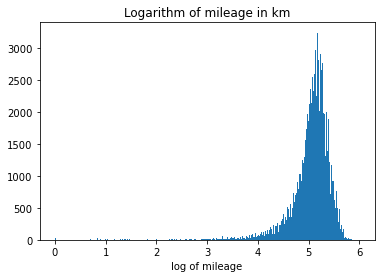

In [28]:
_ = plt.hist(np.log10(df['mileage']),bins = 'auto')
plt.title('Logarithm of mileage in km')
plt.xlabel('log of mileage')
plt.show()

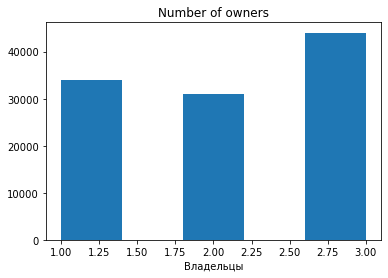

In [29]:
_ = plt.hist(df['Владельцы'],bins = 5)
plt.title('Number of owners')
plt.xlabel('Владельцы')
plt.show()

#### Scatter plots

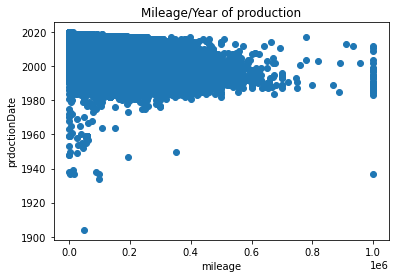

In [30]:
_ = plt.scatter(df['mileage'],df['productionDate'])

plt.title('Mileage/Year of production')
plt.xlabel('mileage')
plt.ylabel('prdoctionDate')

plt.show()

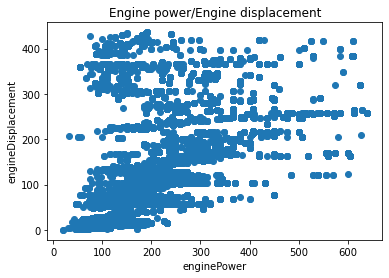

In [31]:
_ = plt.scatter(df['enginePower'],df['engineDisplacement'])

plt.title('Engine power/Engine displacement')
plt.xlabel('enginePower')
plt.ylabel('engineDisplacement')

plt.show()

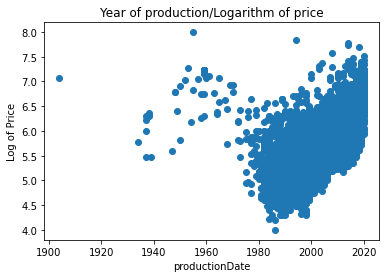

In [32]:
_ = plt.scatter(df['productionDate'],
                np.log10(df['Price']))

plt.title('Year of production/Logarithm of price')
plt.xlabel('productionDate')
plt.ylabel('Log of Price')

plt.show()

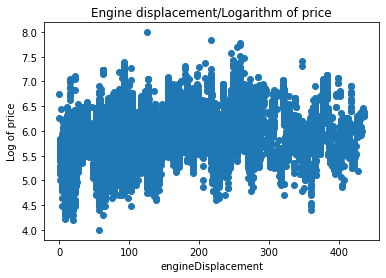

In [33]:
_ = plt.scatter(df['engineDisplacement'],
                np.log10(df['Price']))

plt.title('Engine displacement/Logarithm of price')
plt.xlabel('engineDisplacement')
plt.ylabel('Log of price')

plt.show()

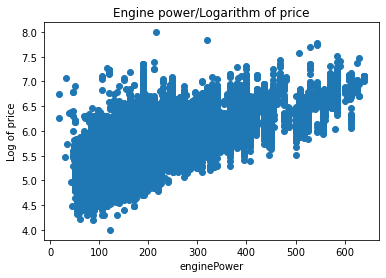

In [34]:
_ = plt.scatter(df['enginePower'],
                np.log10(df['Price']))

plt.title('Engine power/Logarithm of price')
plt.xlabel('enginePower')
plt.ylabel('Log of price')

plt.show()

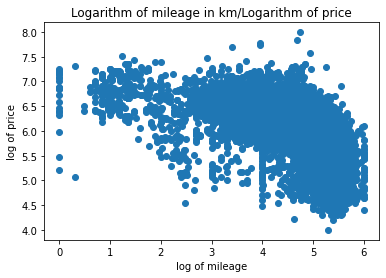

In [35]:
_ = plt.scatter(np.log10(df['mileage']),
                np.log10(df['Price']))

plt.title('Logarithm of mileage in km/Logarithm of price')
plt.xlabel('log of mileage')
plt.ylabel('log of price')

plt.show()

So, as we can see, logarithms of mileage and price have normal distribution. So, we will apply `np.log10` to this columns

In [36]:
df['Price'] = df['Price'].apply(np.log10)
df['mileage'] = df['mileage'].apply(np.log10)

#### Baseline

In [37]:
y = df['Price']
X = df.drop('Price',axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [39]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [40]:
y_pred = X_test['bodyType'].map(tmp_train.groupby('bodyType')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mean_absolute_percentage_error(np.power(10,y_test), np.power(10,y_pred.values)))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 71.35%


## Machine Learning

Set KFold split for validation:

In [41]:
kf = KFold(n_splits=5,shuffle=True,random_state=RANDOM_SEED)

### Sklearn GradientBoostingRegressor

In [42]:
# experimentally derived range of best params
param_grid = {'max_depth':[8,9],
              'n_estimators':[400,500],
              'min_samples_split': [5],
              'min_samples_leaf': [2]}

GRB = GradientBoostingRegressor(loss='ls',random_state=RANDOM_SEED)
GRB_cv = GridSearchCV(GRB, 
                      param_grid=param_grid,
                      cv=3,
                      verbose=10,
                      n_jobs=-1)

GRB_cv.fit(X,y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  3.0min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  3.3min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  3.6min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  5.3min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.0min finished


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [8, 9], 'min_samples_leaf': [2],
                         'min_samples_split': [5], 'n_estimators': [400, 500]},
             verbose=10)

In [43]:
GRB_cv.best_params_

{'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 500}

In [44]:
GRB = GradientBoostingRegressor(max_depth=9, 
                                n_estimators=500,
                                min_samples_leaf=2,
                                min_samples_split=5,
                                loss='ls',
                                random_state=RANDOM_SEED)
fold_number=1
for train, test in kf.split(X,y):
    GRB.fit(X.iloc[train],y.iloc[train])
    
    y_pred = np.power(10,GRB.predict(X.iloc[test]))
    y_test = np.power(10,y.iloc[test])
    
    mape = np.round(mean_absolute_percentage_error(y_test,y_pred)*100, decimals=4)
    mae = int(mean_absolute_error(y_test,y_pred))
    
    print(f'Fold number: {fold_number}')
    print(f'MAPE: {mape} %')
    print(f'MAE:  {mae} RUB\n')
    
    fold_number+=1


Fold number: 1
MAPE: 12.2833 %
MAE:  114911 RUB

Fold number: 2
MAPE: 12.3285 %
MAE:  118457 RUB

Fold number: 3
MAPE: 12.1883 %
MAE:  115662 RUB

Fold number: 4
MAPE: 12.1824 %
MAE:  109865 RUB

Fold number: 5
MAPE: 12.0779 %
MAE:  119177 RUB



### LightGBM Regressor

In [50]:
param_grid={'max_depth':[8,9,10],
           'num_leaves':[2**10],
           'n_estimators':[625,700]}
LGBM = LGBMRegressor(n_jobs=-1,random_state=RANDOM_SEED)
LGBM_cv = GridSearchCV(LGBM, param_grid=param_grid,cv=3,n_jobs=-1,verbose=10)
LGBM_cv.fit(X,y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:   33.2s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:   35.9s remaining:   56.4s
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:   59.2s remaining:   59.2s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:  1.1min remaining:   41.8s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  1.1min remaining:   26.1s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  1.2min remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.3min finished


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10], 'n_estimators': [625, 700],
                         'num_leaves': [1024]},
             verbose=10)

In [52]:
LGBM_cv.best_params_

{'max_depth': 9, 'n_estimators': 625, 'num_leaves': 1024}

In [45]:
LGBM = LGBMRegressor(max_depth=9, 
                     n_estimators=625, 
                     num_leaves=2**9, 
                     n_jobs = -1)

fold_number=1
for train, test in kf.split(X,y):
    LGBM.fit(X.iloc[train],y.iloc[train])
    
    y_pred = np.power(10,LGBM.predict(X.iloc[test]))
    y_test = np.power(10,y.iloc[test])
    
    mape = np.round(mean_absolute_percentage_error(y_test,y_pred)*100, decimals=4)
    mae = int(mean_absolute_error(y_test,y_pred))
    
    print(f'Fold number: {fold_number}')
    print(f'MAPE: {mape} %')
    print(f'MAE:  {mae} RUB\n')
    
    fold_number+=1


Fold number: 1
MAPE: 12.5363 %
MAE:  122254 RUB

Fold number: 2
MAPE: 12.5372 %
MAE:  121665 RUB

Fold number: 3
MAPE: 12.401 %
MAE:  120808 RUB

Fold number: 4
MAPE: 12.3703 %
MAE:  113614 RUB

Fold number: 5
MAPE: 12.3056 %
MAE:  121934 RUB



### XGBoost

In [68]:
param_grid = {'max_depth':[11,12,13,14],
              'n_estimators':[200],
              'learning_rate':[0.10,0.12,0.15,None]
              #'max_features': ['auto', 'sqrt', 'log2'],
             }

XGRB = XGBRegressor(random_state=RANDOM_SEED)
XGRB_cv = GridSearchCV(GRB, 
                      param_grid=param_grid,
                      cv=3,
                      verbose=3,
                      n_jobs=-1)
XGRB_cv.fit(X,y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  7.0min finished


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [73]:
XGRB_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 200}

In [46]:
XGRB = XGBRegressor(max_depth=12, 
            n_estimators=200, 
            learning_rate=0.1,
            n_jobs = -1)

fold_number=1
for train, test in kf.split(X,y):
    XGRB.fit(X.iloc[train],y.iloc[train])
    
    y_pred = np.power(10,XGRB.predict(X.iloc[test]))
    y_test = np.power(10,y.iloc[test])
    
    mape = np.round(mean_absolute_percentage_error(y_test,y_pred)*100, decimals=4)
    mae = int(mean_absolute_error(y_test,y_pred))
    
    print(f'Fold number: {fold_number}')
    print(f'MAPE: {mape} %')
    print(f'MAE:  {mae} RUB\n')
    
    fold_number+=1


Fold number: 1
MAPE: 12.1384 %
MAE:  113503 RUB

Fold number: 2
MAPE: 12.1647 %
MAE:  115682 RUB

Fold number: 3
MAPE: 11.9457 %
MAE:  113499 RUB

Fold number: 4
MAPE: 12.0243 %
MAE:  108494 RUB

Fold number: 5
MAPE: 11.856 %
MAE:  115868 RUB



### CatBoostRegressor

In [81]:
param_grid = {'iterations': [400,500,600],
          'depth': [9,10,11,12,13]
         }
CatGBR = CatBoostRegressor(eval_metric='MAPE',
                           random_state=RANDOM_SEED
                          )

CatGBR_cv = GridSearchCV(CatGBR, param_grid=param_grid,cv=3,n_jobs=-1,verbose=10)
CatGBR_cv.fit(X,y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  1.0min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  1.6min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.6min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  2.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  4.4min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  4.7min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.0min finished


Learning rate set to 0.132653
0:	learn: 0.0435383	total: 46.1ms	remaining: 27.6s
1:	learn: 0.0387635	total: 102ms	remaining: 30.6s
2:	learn: 0.0345640	total: 151ms	remaining: 30.1s
3:	learn: 0.0308619	total: 203ms	remaining: 30.2s
4:	learn: 0.0278334	total: 254ms	remaining: 30.3s
5:	learn: 0.0253220	total: 306ms	remaining: 30.3s
6:	learn: 0.0231329	total: 358ms	remaining: 30.3s
7:	learn: 0.0212337	total: 410ms	remaining: 30.3s
8:	learn: 0.0196640	total: 463ms	remaining: 30.4s
9:	learn: 0.0183908	total: 514ms	remaining: 30.3s
10:	learn: 0.0171890	total: 565ms	remaining: 30.3s
11:	learn: 0.0162560	total: 616ms	remaining: 30.2s
12:	learn: 0.0154626	total: 670ms	remaining: 30.3s
13:	learn: 0.0148109	total: 721ms	remaining: 30.2s
14:	learn: 0.0142870	total: 772ms	remaining: 30.1s
15:	learn: 0.0137651	total: 821ms	remaining: 30s
16:	learn: 0.0134188	total: 876ms	remaining: 30.1s
17:	learn: 0.0131177	total: 928ms	remaining: 30s
18:	learn: 0.0127774	total: 980ms	remaining: 30s
19:	learn: 0.012

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000027EA1D7AD60>,
             n_jobs=-1,
             param_grid={'depth': [9, 10, 11, 12, 13], 'iterations': [600]},
             verbose=10)

In [82]:
CatGBR_cv.best_params_

{'depth': 11, 'iterations': 600}

In [47]:
CatGBR = CatBoostRegressor(iterations = 600,
                          depth=11,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                         )
cat_features_ids=['brand','bodyType','color','fuelType','vehicleConfiguration','Привод','Руль','ПТС']

fold_number=1
for train, test in kf.split(X,y):
    CatGBR.fit(X.iloc[train], y.iloc[train],
         #cat_features=cat_features_ids,
         eval_set=(X.iloc[test], y.iloc[test]),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

    
    y_pred = np.power(10,CatGBR.predict(X.iloc[test]))
    y_test = np.power(10,y.iloc[test])
    
    mape = np.round(mean_absolute_percentage_error(y_test,y_pred)*100, decimals=4)
    mae = int(mean_absolute_error(y_test,y_pred))
    
    print(f'Fold number: {fold_number}')
    print(f'MAPE: {mape} %')
    print(f'MAE:  {mae} RUB\n')
    
    fold_number+=1


Fold number: 1
MAPE: 12.5058 %
MAE:  120697 RUB

Fold number: 2
MAPE: 12.4572 %
MAE:  122159 RUB

Fold number: 3
MAPE: 12.3323 %
MAE:  119689 RUB

Fold number: 4
MAPE: 12.385 %
MAE:  113586 RUB

Fold number: 5
MAPE: 12.275 %
MAE:  120480 RUB



### Stacking

In [48]:
estimators = [('GradientBoostingRegressor',GRB),
             ('LightGBM',LGBM),
             ('XGBoost',XGRB)]

stacking = StackingRegressor(estimators=estimators,
                             final_estimator=LinearRegression(),
                             cv=3,
                             n_jobs=-1,
                             verbose=1)
stacking.fit(X_train,y_train)

StackingRegressor(cv=3,
                  estimators=[('GradientBoostingRegressor',
                               GradientBoostingRegressor(max_depth=9,
                                                         min_samples_leaf=2,
                                                         min_samples_split=5,
                                                         n_estimators=500,
                                                         random_state=42)),
                              ('LightGBM',
                               LGBMRegressor(max_depth=9, n_estimators=625,
                                             num_leaves=512)),
                              ('XGBoost',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsamp...
                                            interactio

## Submission

In [51]:
sub_predict = np.power(10,stacking.predict(submission_data.drop(['modelDate'],axis=1)))

In [52]:
sub_predict

array([ 425699.49311353,  718231.85942402,  671451.74085256, ...,
        261825.92555582, 1068614.97385421,  950300.31648349])

In [53]:
sell_id = pd.read_csv('submission_data.csv')['sell_id']

In [54]:
submission_data['sell_id']=sell_id

In [55]:
submission_data['price'] = sub_predict

In [56]:
VERSION = 6
submission_data[['sell_id','price']].to_csv(f'submission_price_v{VERSION}.csv',index=False)

## What's next?

- Improved FE
- Special libraries for models tuning (hyperopt, optuna, Bayesian Optimization)

## Links
#### Parsed data: 
- https://www.kaggle.com/sokolovaleks/parsing-all-moscow-auto-ru-09-09-2020
- https://www.kaggle.com/macsunmood/autoru-parsed-0603-1304